In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
funds = [{'fund_cd': '2008010903', 'fund_name': 'SMT TOPIXインデックス･オープン', 'asset_class': '国内株式'}, 
        {'fund_cd': '2008010904', 'fund_name': 'SMT グローバル株式インデックス', 'asset_class': '先進国株式'},
        {'fund_cd': '2008040102', 'fund_name': 'インデックスF海外新興国株式', 'asset_class': '新興国株式'},
        {'fund_cd': '2008010905', 'fund_name': 'SMT 国内債券インデックス･オープン', 'asset_class': '国内債券'},
        {'fund_cd': '2008010906', 'fund_name': 'SMT グローバル債券インデックス', 'asset_class': '先進国債券'},
        {'fund_cd': '2008040103', 'fund_name': 'インデックスF海外新興国債券(1年決算型)', 'asset_class': '新興国債券'}, 
        {'fund_cd': '2008010907', 'fund_name': 'SMT J-REITインデックス･オープン', 'asset_class': '国内リート'},
        {'fund_cd': '2008010908', 'fund_name': 'SMT グローバルREITインデックス', 'asset_class': '先進国リート'}
       ]

In [4]:
fundsdata = pd.read_csv('csv/'+funds[0]['fund_cd']+'.csv')
fundsdata = fundsdata.drop('基準価額', axis=1)
for fund in funds:
    df = pd.read_csv('csv/'+fund['fund_cd']+'.csv')
    df = df.rename(columns={'基準価額': fund['asset_class']})
    fundsdata = pd.merge(fundsdata, df, on='日付')
fundsdata.columns = ['date','jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit']

In [5]:
fundsdata= fundsdata.query('date >= 20180101 and date < 20230101')
fundsdata.reset_index(inplace=True, drop=True)

In [6]:
# 最適ポートフォリオリバランスなし
ganpon = 1000000
portbase = fundsdata.drop('date', axis=1)
# init_weight = pd.read_csv('port.csv',names=portbase.columns)
init_weight = pd.read_csv('port_eq.csv',names=portbase.columns)

In [7]:
# 数量、評価額、ポートフォリオ全体の評価額を計算
init_val = ganpon*init_weight
init_num = init_val*10000/portbase.loc[0]
nums_noreb = pd.DataFrame(np.ones((len(fundsdata.index),8)),columns=portbase.columns)
val_noreb = nums_noreb.copy()
port_noreb = pd.DataFrame(np.ones((len(fundsdata.index),1)),columns=['port'])
alc_noreb = nums_noreb.copy()

In [8]:
for index, row in nums_noreb.iterrows():
    nums_noreb.loc[index] = init_num.loc[0]
    val_noreb.loc[index] = nums_noreb.loc[index] * portbase.loc[index] /10000
    port_noreb.loc[index] = val_noreb.loc[index].sum()
    alc_noreb.loc[index] = val_noreb.loc[index]/port_noreb.loc[index]

In [54]:
for index, row in alc_noreb.iterrows():
    alc_noreb.loc[index] = val_noreb.loc[index]/port_noreb.loc[index].values

In [53]:
val_noreb.loc[index]/port_noreb.loc[index].values

jp_stock          0.120800
foreign_stock     0.171297
emerging_stock    0.110915
jp_bond           0.101789
foreign_bond      0.110873
emerging_bond     0.104234
jp_reit           0.145704
foreign_reit      0.134388
Name: 1217, dtype: float64

In [9]:
# 最適ポートフォリオ四半期リバランス
nums_rebq = nums_noreb.copy()
vals_rebq = nums_rebq.copy()
port_rebq = pd.DataFrame(np.ones((len(fundsdata.index),1)),columns=['port'])
alc_rebq = nums_rebq.copy()

In [10]:
qdays=[20180104,	20180402,	20180702,	20181001,	20190104,	20190401,	20190701,	20191001,	20200106,	20200401,	20200701,	20201001,	20210104,	20210401,	20210701,	20211001,	20220104,	20220401,	20220701,	20221003]


In [11]:
for index, row in vals_rebq.iterrows():
    if index == 0:
        nums_rebq.loc[index] = nums_rebq.loc[index]
        vals_rebq.loc[index] = nums_rebq.loc[index] *fundsdata.loc[index,vals_rebq.columns]/10000
    elif fundsdata.loc[index, 'date'] in qdays:
        v=vals_rebq.loc[index-1].sum()*init_weight
        vals_rebq.loc[index] = v.loc[0]
        nums_rebq.loc[index] = vals_rebq.loc[index]*10000/fundsdata.loc[index,vals_rebq.columns]
    else:
        nums_rebq.loc[index] = nums_rebq.loc[index-1]
        vals_rebq.loc[index] = nums_rebq.loc[index] *fundsdata.loc[index,vals_rebq.columns]/10000

In [12]:
port_rebq = vals_rebq.sum(axis=1)
for index, row in alc_rebq.iterrows():
    alc_rebq.loc[index] = vals_rebq.loc[index]/port_rebq.loc[index]

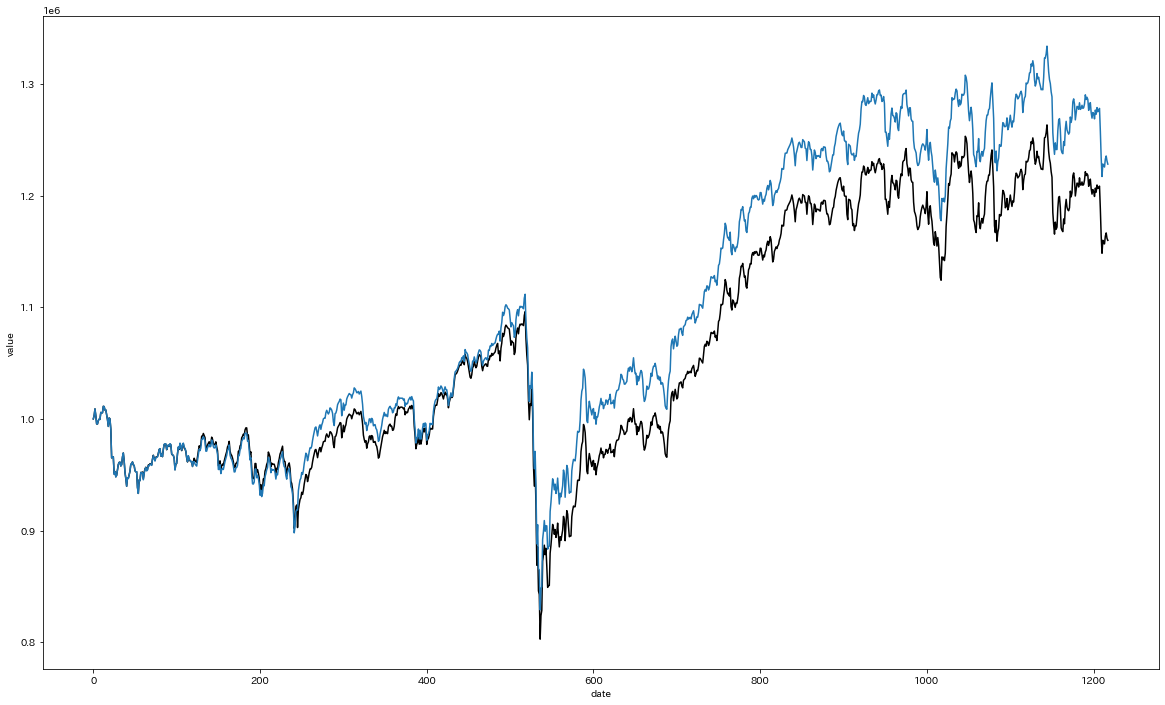

In [13]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, xlabel='date', ylabel='value')

ax.plot(port_noreb,c='k')
ax.plot(port_rebq)

In [14]:
# vaeリバランス
difs=pd.read_csv('difs_5y.csv', index_col=0)
difs['shift'] = difs['dif'] - difs['dif'].shift()

In [15]:
difs['roll'] = difs['shift'].rolling(10, win_type='gaussian').sum(std=5)

/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


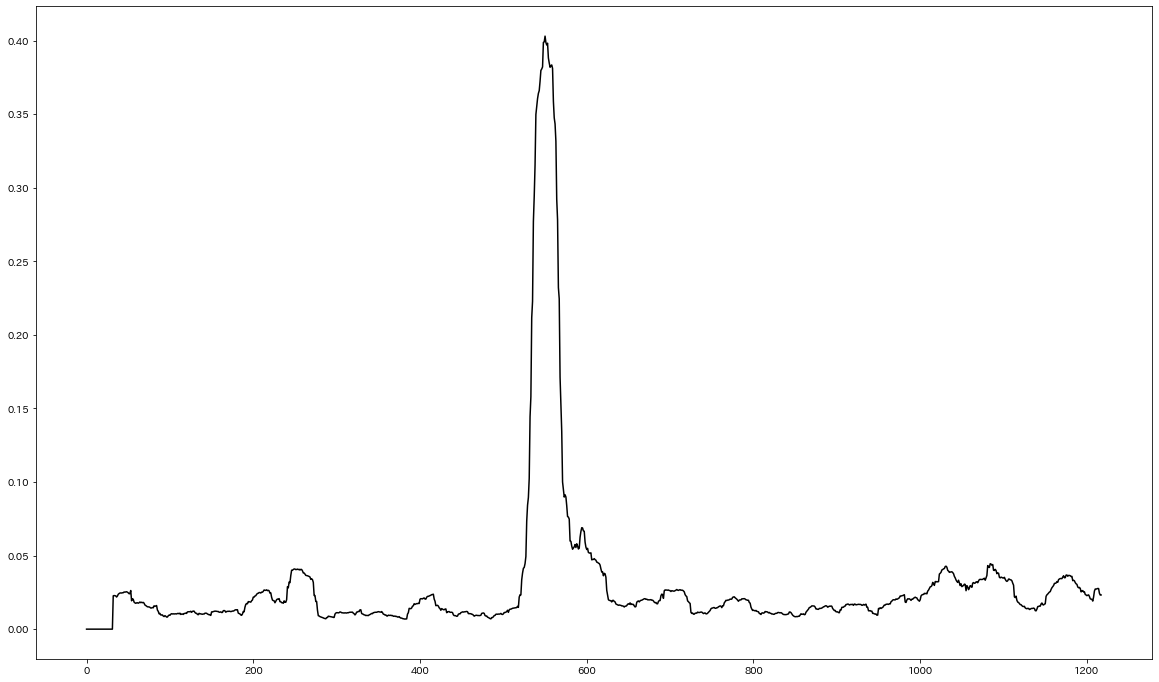

In [16]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)

ax.plot(difs['dif'],c='k')
# ax.plot(difs['shift'],c='k')
# ax.plot(difs['roll'],c='k')

In [17]:
vdays=[]
vins=[]
thrd=0.03
reb_interbal=5
for index, row in difs.iterrows():
    if difs.loc[index]['dif'] > thrd and (len(vdays)==0 or vins[-1]+reb_interbal<index):
        vins.append(index)
        vdays.append(difs.loc[index]['date'])

In [18]:
nums_rebv = nums_noreb.copy()
vals_rebv = nums_rebv.copy()
port_rebv = pd.DataFrame(np.ones((len(fundsdata.index),1)),columns=['port'])
alc_rebv = nums_rebv.copy()

In [19]:
for index, row in vals_rebv.iterrows():
    if index == 0:
        nums_rebv.loc[index] = nums_rebv.loc[index]
        vals_rebv.loc[index] = nums_rebv.loc[index] *fundsdata.loc[index,vals_rebv.columns]/10000
    elif fundsdata.loc[index, 'date'] in vdays:
        v=vals_rebv.loc[index-1].sum()*init_weight
        vals_rebv.loc[index] = v.loc[0]
        nums_rebv.loc[index] = vals_rebv.loc[index]*10000/fundsdata.loc[index,vals_rebv.columns]
    else:
        nums_rebv.loc[index] = nums_rebv.loc[index-1]
        vals_rebv.loc[index] = nums_rebv.loc[index] *fundsdata.loc[index,vals_rebv.columns]/10000

In [20]:
port_rebv = vals_rebv.sum(axis=1)
for index, row in alc_rebv.iterrows():
    alc_rebv.loc[index] = vals_rebv.loc[index]/port_rebv.loc[index]

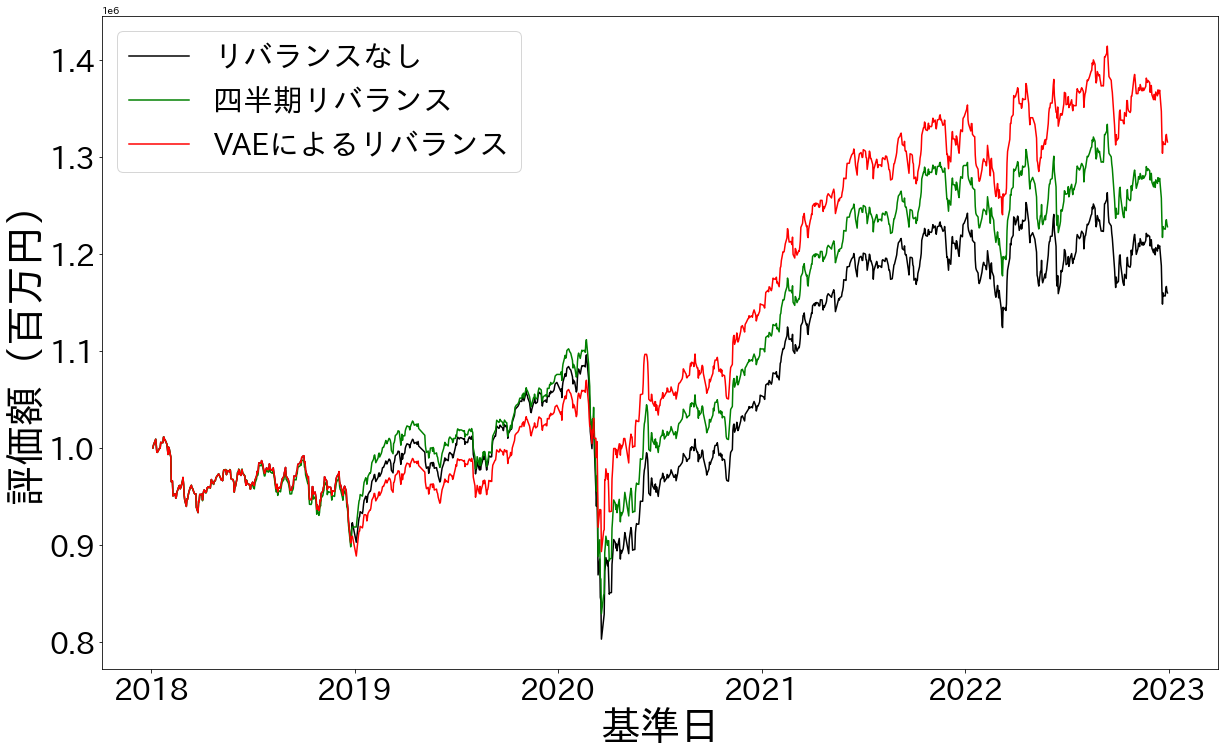

In [57]:
import datetime
import japanize_matplotlib

lb = ['リバランスなし','四半期リバランス','VAEによるリバランス']
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, xlabel='date', ylabel='value')

ax.plot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),port_noreb,c='k')
ax.plot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),port_rebq,c='g')
ax.plot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),port_rebv,c='r')

ax.legend(labels=lb,fontsize=30)
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('評価額（百万円）', size=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
fig.savefig("ope.png")

In [33]:
print(round((port_noreb.tail(1)['port'].values[0]/1000000-1)*100,2))
print(round((port_rebq.tail(1).values[0]/1000000-1)*100,2))
print(round((port_rebv.tail(1).values[0]/1000000-1)*100,2))

15.99
22.81
31.55


In [34]:
print(round(((port_noreb.tail(1)['port'].values[0]/1000000)**(250/1218)-1)*100,2))
print(round(((port_rebq.tail(1).values[0]/1000000)**(250/1218)-1)*100,2))
print(round(((port_rebv.tail(1).values[0]/1000000)**(250/1218)-1)*100,2))

3.09
4.31
5.79


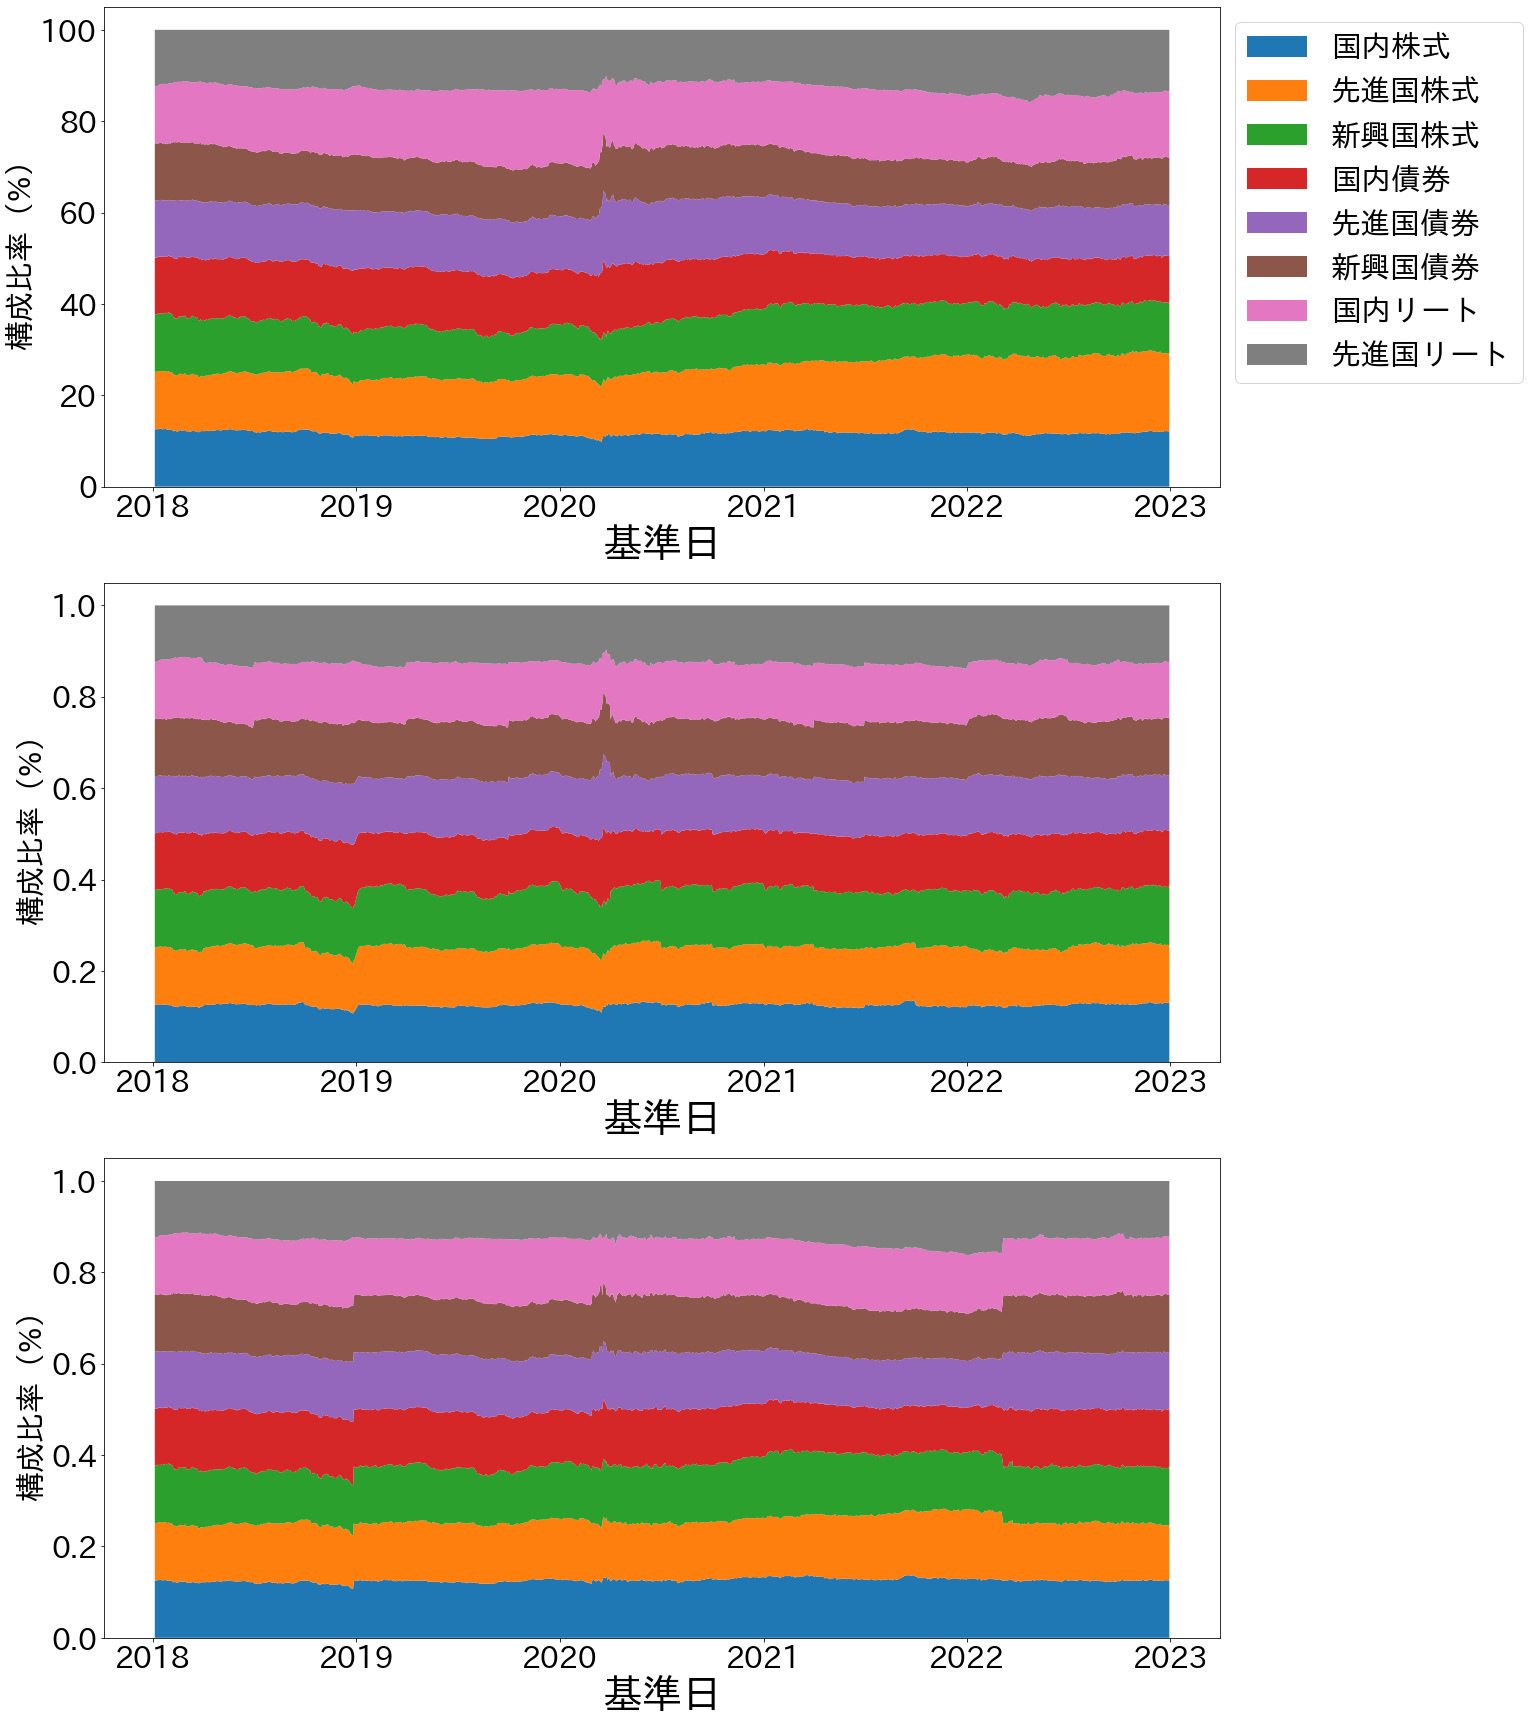

In [65]:
import datetime
import japanize_matplotlib

jp=['国内株式','先進国株式','新興国株式', '国内債券', '先進国債券','新興国債券','国内リート','先進国リート']
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(311, xlabel='date', ylabel='value')
ax.stackplot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),alc_noreb.values.T*100)
ax.legend(labels=jp,fontsize=30,loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('構成比率（%）', size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax = fig.add_subplot(312, xlabel='date', ylabel='value')
ax.stackplot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),alc_rebq.values.T)
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('構成比率（%）', size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax = fig.add_subplot(313, xlabel='date', ylabel='value')
ax.stackplot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),alc_rebv.values.T)
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('構成比率（%）', size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

fig.savefig("mens.png")

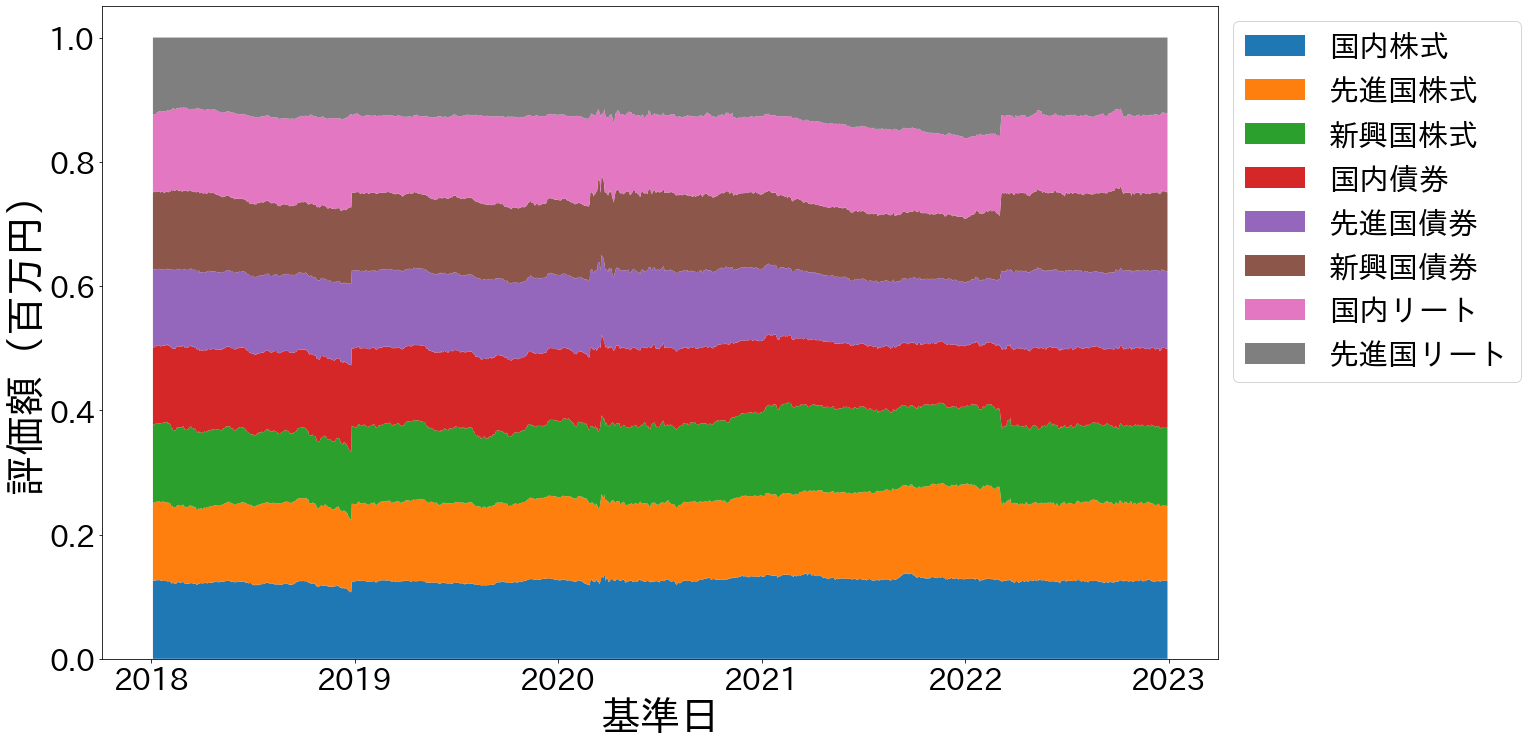

In [45]:
import datetime
import japanize_matplotlib

jp=['国内株式','先進国株式','新興国株式', '国内債券', '先進国債券','新興国債券','国内リート','先進国リート']
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, xlabel='date', ylabel='value')

ax.stackplot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),alc_rebv.values.T)

ax.legend(labels=jp,fontsize=30,loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('評価額（百万円）', size=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
fig.savefig("men_rebv.png")

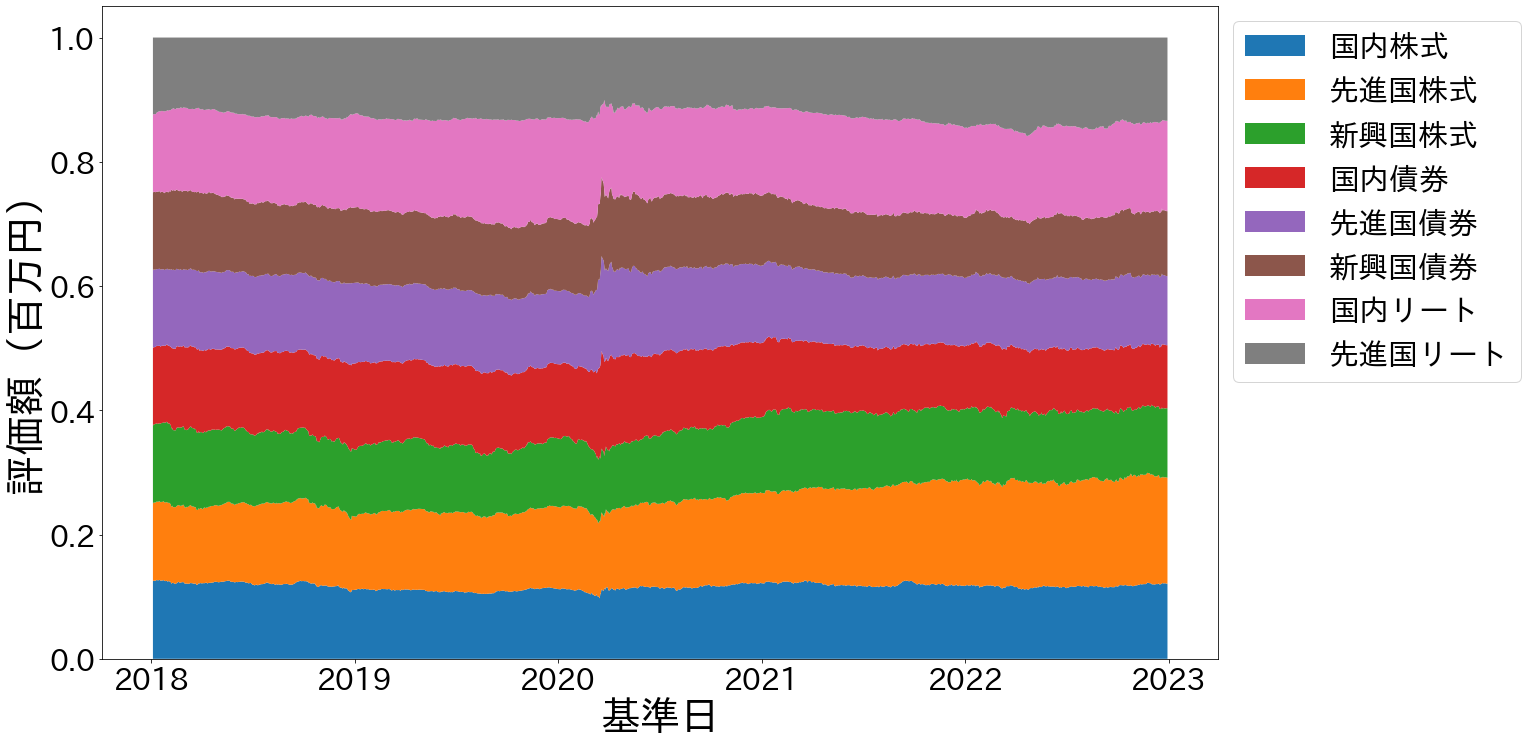

In [55]:
import datetime
import japanize_matplotlib

jp=['国内株式','先進国株式','新興国株式', '国内債券', '先進国債券','新興国債券','国内リート','先進国リート']
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, xlabel='date', ylabel='value')

ax.stackplot(pd.to_datetime(fundsdata['date'], format='%Y%m%d'),alc_noreb.values.T)

ax.legend(labels=jp,fontsize=30,loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('基準日', size=40)
ax.set_ylabel('評価額（百万円）', size=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
fig.savefig("men_noreb.png")